### Load Libraries

In [2]:
# DL packages
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# ML packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

### Load data

In [3]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [4]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [5]:
train_data.shape

(16000, 3)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  16000 non-null  object
 1   Emotion  16000 non-null  object
 2   length   16000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [6]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

### EDA

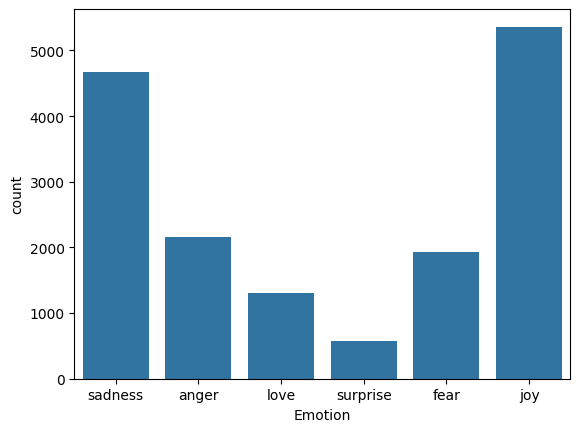

In [7]:
sns.countplot(x=train_data['Emotion'])
plt.show()

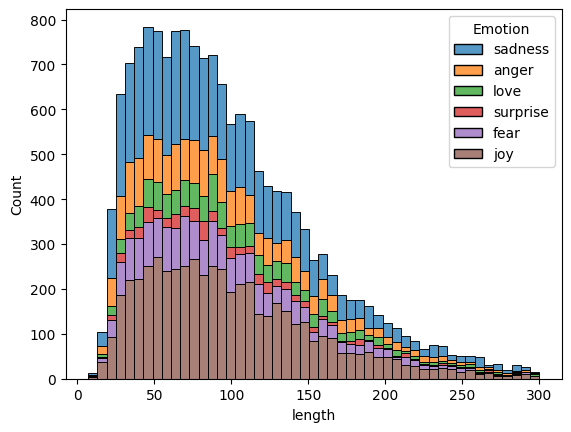

In [9]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the length column to numpy array
length_values = df2['length'].values

# Use sns.histplot 
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

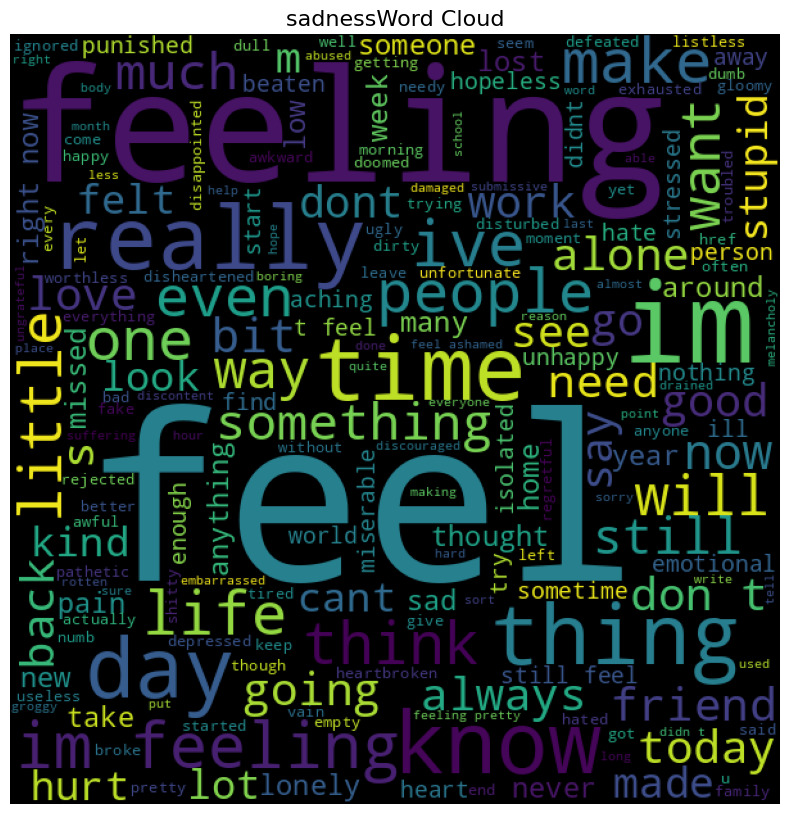

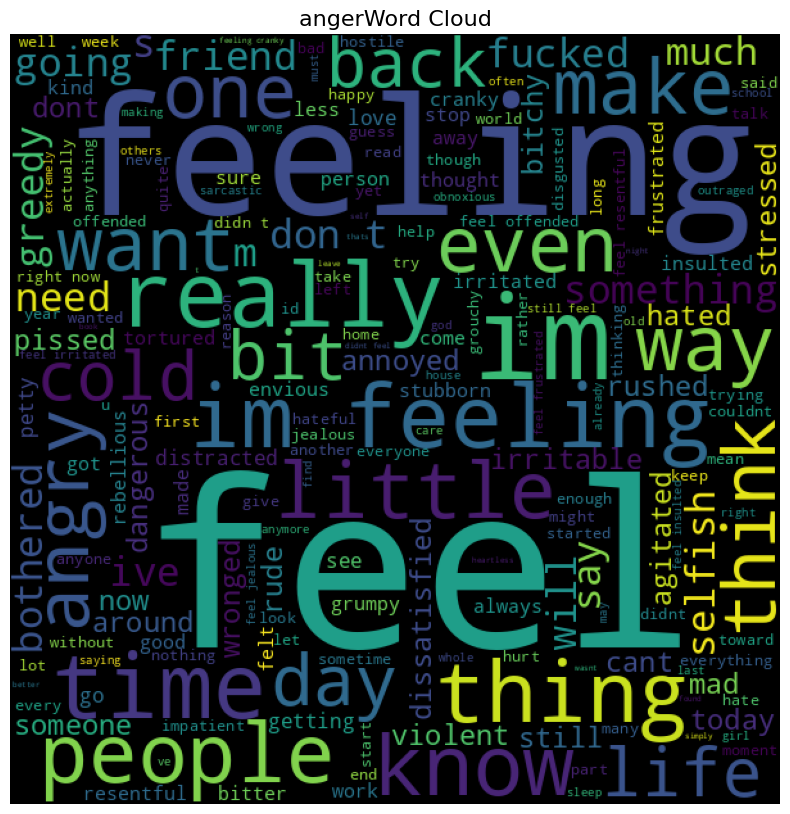

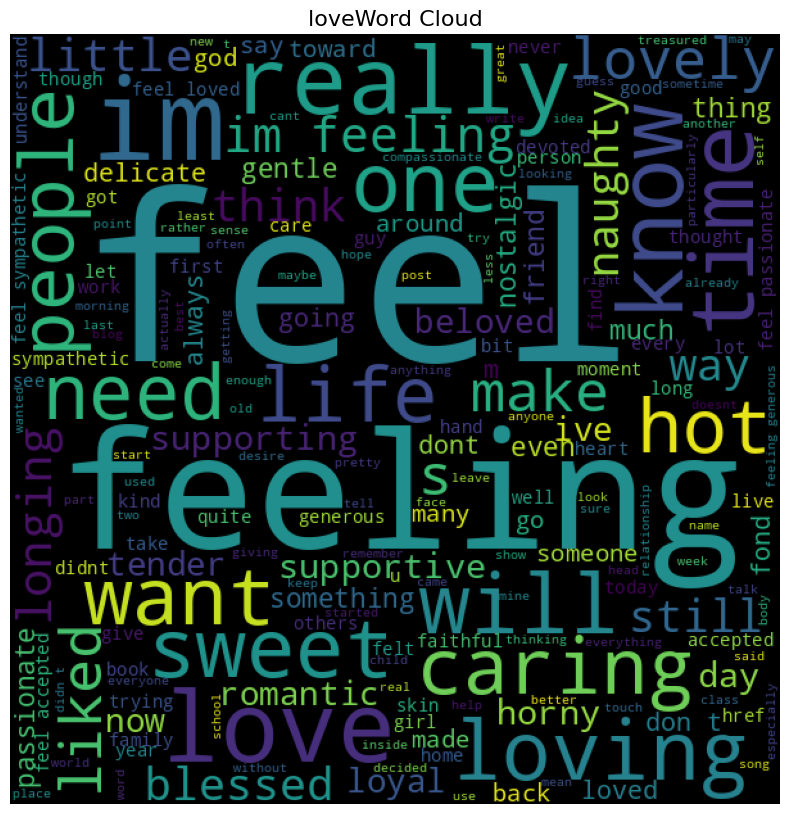

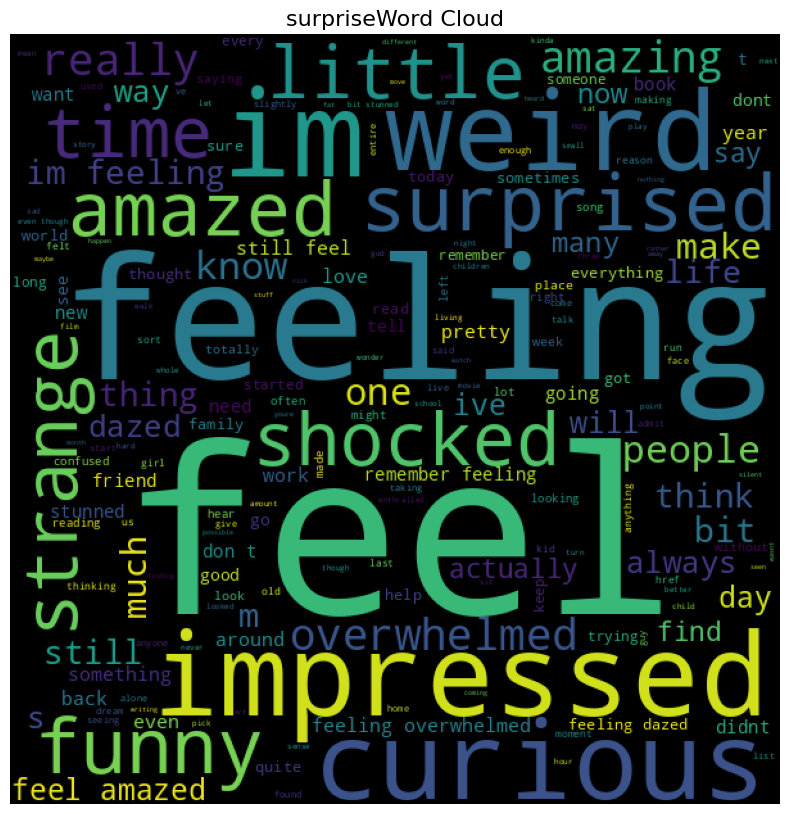

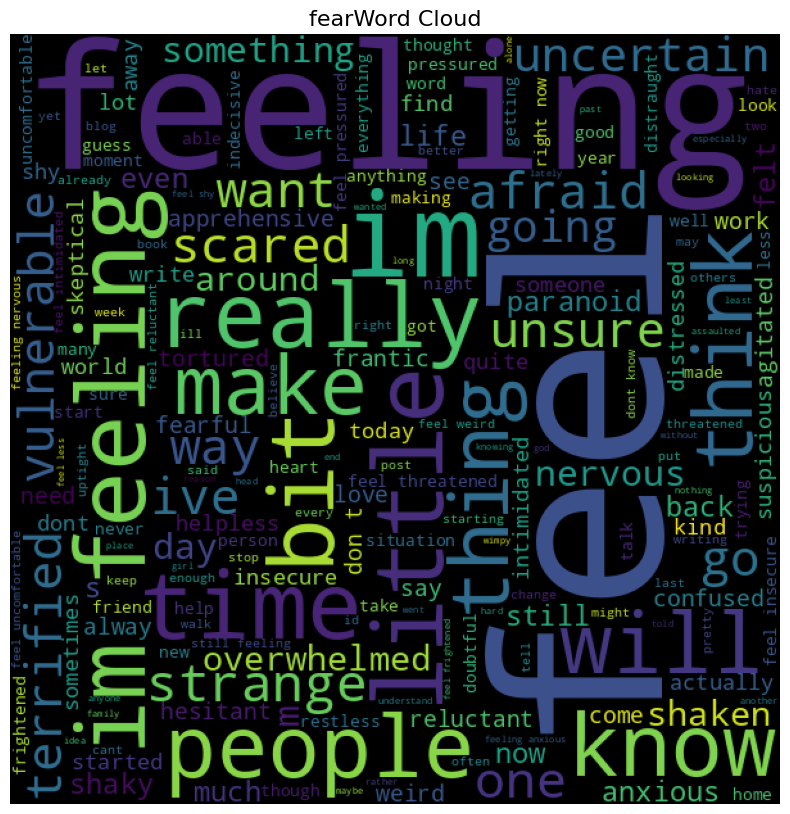

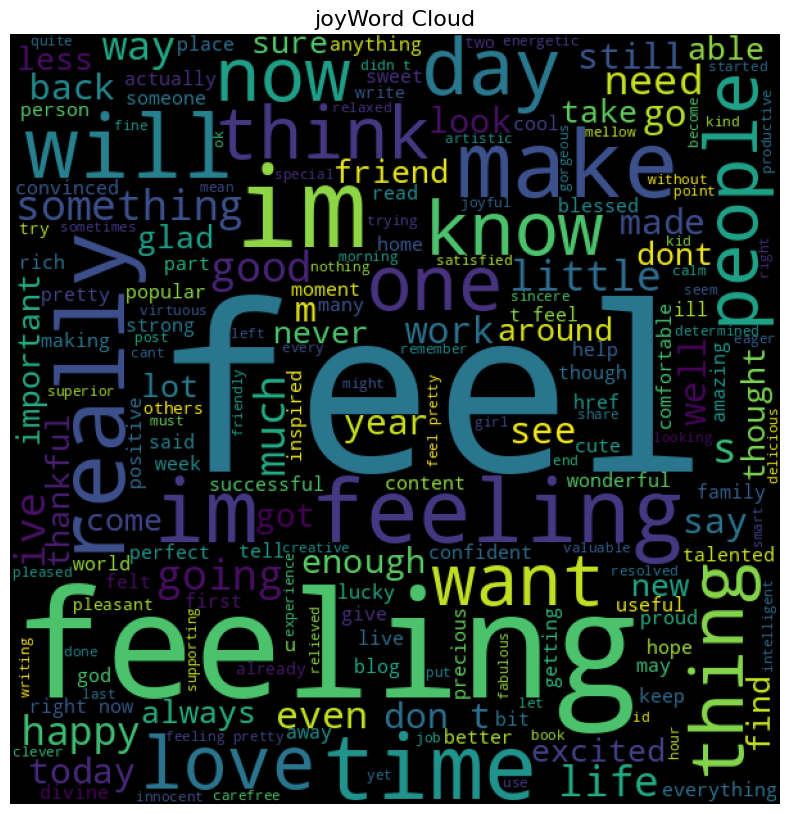

In [10]:
# Word cloud for each emotion
def word_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df + 'Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off")
    
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion, 'Comment']])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    word_cloud(wordcloud, emotion)    

### Data Preprocessing

### Encode Emotions

In [11]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [12]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


### Applying Machine Learning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = train_data.copy() # using for DL 

In [15]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [16]:
# data cleaning and preprocessing
# download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [20]:
df['cleaned_comment'][0] 

'didnt feel humili'

In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size=0.2, random_state=42)

In [22]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [23]:
# Multi class classification using diifferent algo
classifiers = {
    "Multinomial Naive Bayes":MultinomialNB(),
    "Logistic Regression":LogisticRegression(),
    "Random Forest":RandomForestClassifier(),
    "Support Vector Machine":SVC()
}

for name, clf in classifiers.items():
    print(f"\n====== {name}======")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\n Accuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report: ")
    print(classification_report(y_test, y_pred_tfidf))


====== Multinomial Naive Bayes======

 Accuracy using TF-IDF: 0.655
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


====== Logistic Regression======

 Accuracy using TF-IDF: 0.829375
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
 

In [24]:
# selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [28]:
lg_y_pred

array([4, 2, 4, ..., 2, 2, 4])

In [29]:
# predictive system

def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorizer = tfidf_vectorizer.transform([cleaned_text])
    
    # Predict emotion
    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorizer))
    
    return predicted_emotion, label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]

for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction: ", pred_emotion)
    print("Label: ", label)
    print("====================================================================================")

i didnt feel humiliated
Prediction:  sadness
Label:  4
i feel strong and good overall
Prediction:  joy
Label:  2
im grabbing a minute to post i feel greedy wrong
Prediction:  anger
Label:  0
He was speechles when he found out he was accepted to this new job
Prediction:  joy
Label:  2
This is outrageous, how can you talk like that?
Prediction:  anger
Label:  0
I feel like im all alone in this world
Prediction:  sadness
Label:  4
He is really sweet and caring
Prediction:  love
Label:  3
You made me very crazy
Prediction:  sadness
Label:  4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction:  love
Label:  3
i am feeling grouchy
Prediction:  anger
Label:  0
He hates you
Prediction:  anger
Label:  0


In [30]:
#save files
import pickle
pickle.dump(lg, open("logistic_regression.pkl", 'wb'))
pickle.dump(lb, open("llabel_encoder.pkl", 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", 'wb'))

In [31]:
import sklearn
print(sklearn.__version__)

1.5.1


### Applying Deep learning Using LSTM

### Text Cleaning, Ecoding, and Padding

In [32]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

### Model Building and Training

In [33]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 16s 35ms/step - loss: 1.4696 - accuracy: 0.4091
Epoch 2/10
250/250 [==============================] - 9s 36ms/step - loss: 0.6511 - accuracy: 0.7859
Epoch 3/10
250/250 [==============================] - 8s 34ms/step - loss: 0.3446 - accuracy: 0.8841
Epoch 4/10
250/250 [==============================] - 9s 36ms/step - loss: 0.2353 - accuracy: 0.9247
Epoch 5/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1753 - accuracy: 0.9437
Epoch 6/10
250/250 [==============================] - 9s 35ms/step - loss: 0.1462 - accuracy: 0.9498
Epoch 7/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1221 - accuracy: 0.9590
Epoch 8/10
250/250 [==============================] - 9s 36ms/step - loss: 0.0991 - accuracy: 0.9661
Epoch 9/10
250/250 [==============================] - 9s 36ms/step - loss: 0.0881 - accuracy: 0.9704
Epoch 10/10
250/250 [==============================] - 9s 36ms/step - loss: 0.0833 - accur

### Predictive System

In [34]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 [==============================] - 0s 37ms/step
joy : 0.999022364616394


im grabbing a minute to post i feel greedy wrong
1/1 [==============================] - 0s 38ms/step
anger : 0.9973577857017517


He was speechles when he found out he was accepted to this new job
1/1 [==============================] - 0s 39ms/step
joy : 0.6242679357528687


This is outrageous, how can you talk like that?
1/1 [==============================] - 0s 32ms/step
anger : 0.9764652848243713


I feel like im all alone in this world
1/1 [==============================] - 0s 31ms/step
sadness : 0.9804397225379944


He is really sweet and caring
1/1 [==============================] - 0s 31ms/step
love : 0.9212673306465149


You made me very crazy
1/1 [==============================] - 0s 39ms/step
sadness : 0.5038045644760132


i am ever feeling nostalgic about the fireplace i will know that it is still on the property
1/1 [==============================] - 0s 31ms/step
lov

### Save the model and files

In [35]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

In [36]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.10.0
2.10.0
